In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Idea
Create the diagonal of the fock matrix via nn, then use gwh to create rest of the fock matrix

# Data 

In [2]:
data_path = "../thesis/dataset/EthenT/"
postfix = "EthenT"
dim = 72
N_ELECTRONS = 16
basis = "6-311++g**"
subfolder = "EmbeddedBlocks/"

#data_path = "../../../cc2ai/ethen/"
#postfix = "_ethen_6-31g**"
#dim = 48
#N_ELECTRONS = 16
#basis = "6-31g**"

#data_path = "../thesis/dataset/TSmall_sto3g"
#postfix = "TSmall_sto3g"
#dim = 26
#N_ELECTRONS = 30
#basis = "sto-3g"

#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26

In [3]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split
from pyscf.scf import hf


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#S, P = np.load(join(data_path, "dataset" + postfix + ".npy"))
S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

#index = np.load(join(data_path, "index" + postfix + ".npy"))


ind = int(0.8 * len(S))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])



h_test = [hf.get_hcore(mol.get_pyscf_molecule()) for mol in molecules[1]]

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)
#s_test, p_test = S.reshape(-1, dim, dim), P.reshape(-1, dim, dim)

In [4]:
def fock_from_density_batch(p_batch):
    f = []
    for p, s, h, mol in zip(p_batch, s_test, h_test, molecules[1]):
        f.append(hf.get_fock(None, h1e=h, s1e=s, vhf=hf.get_veff(mol=mol.get_pyscf_molecule(), dm=p), dm=p))
    return np.array(f)

f_test = fock_from_density_batch(p_test)

In [5]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    train=(s_train, p_train),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)

# Calculate classical Guesses 

In [6]:
from pyscf.scf import hf

In [7]:
p_gwh = [
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]

# GWH Scheme

TODO: decide on the best k!

In [8]:
from SCFInitialGuess.utilities.dataset import density_from_fock

def density_from_fock_batch(f_batch):
    p = []
    for (s, f, mol) in zip(s_test, f_batch, molecules[1]):
        p.append(density_from_fock(f, s, mol.get_pyscf_molecule()))
    return np.array(p)

def gwh_scheme(F, k=1.75):
    
    K = np.ones((dim, dim)) * k - \
            np.diag(np.ones(dim)) * (k - 1)  
    
    f = []
    
    # creat fock matrix
    for d, s in zip(F, s_test):
        
        d = np.diag(d)
        
        f.append(
            K * np.add.outer(d, d) * s / 2
        )
        
    return np.array(f)
    

In [14]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.analysis import mf_initializer
    
print(make_results_str(measure_all_quantities(
    density_from_fock_batch(gwh_scheme(h_test)),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-12-23 18:15:31: Iteration calculation: 0
[ ] 2018-12-23 18:15:32: Iteration calculation: 1
[ ] 2018-12-23 18:15:33: Iteration calculation: 2
[ ] 2018-12-23 18:15:34: Iteration calculation: 3
[ ] 2018-12-23 18:15:35: Iteration calculation: 4
[ ] 2018-12-23 18:15:36: Iteration calculation: 5
[ ] 2018-12-23 18:15:37: Iteration calculation: 6
[ ] 2018-12-23 18:15:38: Iteration calculation: 7
[ ] 2018-12-23 18:15:39: Iteration calculation: 8
[ ] 2018-12-23 18:15:40: Iteration calculation: 9
[ ] 2018-12-23 18:15:41: Iteration calculation: 10
[ ] 2018-12-23 18:15:42: Iteration calculation: 11
[ ] 2018-12-23 18:15:43: Iteration calculation: 12
[ ] 2018-12-23 18:15:44: Iteration calculation: 13
[ ] 2018-12-23 18:15:45: Iteration calculation: 14
[ ] 2018-12-23 18:15:46: Iteration calculation: 15
[ ] 2018-12-23 18:15:47: Iteration calculation: 16
[ ] 2018-12-23 18:15:47: Iteration calculation: 17
[ ] 2018-12-23 18:15:48: Iteration calculation: 18
[ ] 2018-12-23 18:15:49: Iteration calcul

[ ] 2018-12-23 18:18:10: Iteration calculation: 160
[ ] 2018-12-23 18:18:11: Iteration calculation: 161
[ ] 2018-12-23 18:18:13: Iteration calculation: 162
[ ] 2018-12-23 18:18:13: Iteration calculation: 163
[ ] 2018-12-23 18:18:15: Iteration calculation: 164
[ ] 2018-12-23 18:18:16: Iteration calculation: 165
[ ] 2018-12-23 18:18:17: Iteration calculation: 166
[ ] 2018-12-23 18:18:18: Iteration calculation: 167
[ ] 2018-12-23 18:18:19: Iteration calculation: 168
[ ] 2018-12-23 18:18:20: Iteration calculation: 169
[ ] 2018-12-23 18:18:21: Iteration calculation: 170
[ ] 2018-12-23 18:18:22: Iteration calculation: 171
[ ] 2018-12-23 18:18:23: Iteration calculation: 172
[ ] 2018-12-23 18:18:23: Iteration calculation: 173
[ ] 2018-12-23 18:18:25: Iteration calculation: 174
[ ] 2018-12-23 18:18:26: Iteration calculation: 175
[ ] 2018-12-23 18:18:27: Iteration calculation: 176
[ ] 2018-12-23 18:18:29: Iteration calculation: 177
[ ] 2018-12-23 18:18:30: Iteration calculation: 178
[ ] 2018-12-

# Extended Hückel 

In [9]:
f_nn_gwh = gwh_scheme(f_test, k=1.75)

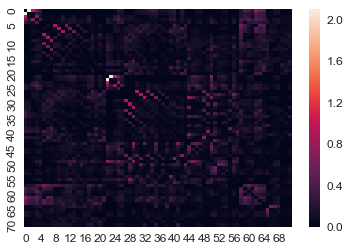

In [10]:
sns.heatmap(np.abs(f_nn_gwh[0] - f_test[0]))

In [11]:
p_nn_gwh = density_from_fock_batch(f_nn_gwh)

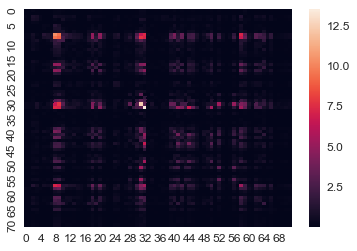

In [12]:
sns.heatmap(np.abs(p_nn_gwh[0] - p_test[0]))

In [13]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.analysis import mf_initializer
    
print(make_results_str(measure_all_quantities(
    p_nn_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-12-23 17:51:31: Iteration calculation: 0
[ ] 2018-12-23 17:51:33: Iteration calculation: 1
[ ] 2018-12-23 17:51:33: Iteration calculation: 2
[ ] 2018-12-23 17:51:34: Iteration calculation: 3
[ ] 2018-12-23 17:51:36: Iteration calculation: 4
[ ] 2018-12-23 17:51:37: Iteration calculation: 5
[ ] 2018-12-23 17:51:38: Iteration calculation: 6
[ ] 2018-12-23 17:51:38: Iteration calculation: 7
[ ] 2018-12-23 17:51:39: Iteration calculation: 8
[ ] 2018-12-23 17:51:39: Iteration calculation: 9
[ ] 2018-12-23 17:51:40: Iteration calculation: 10
[ ] 2018-12-23 17:51:41: Iteration calculation: 11
[ ] 2018-12-23 17:51:41: Iteration calculation: 12
[ ] 2018-12-23 17:51:42: Iteration calculation: 13
[ ] 2018-12-23 17:51:44: Iteration calculation: 14
[ ] 2018-12-23 17:51:44: Iteration calculation: 15
[ ] 2018-12-23 17:51:45: Iteration calculation: 16
[ ] 2018-12-23 17:51:45: Iteration calculation: 17
[ ] 2018-12-23 17:51:46: Iteration calculation: 18
[ ] 2018-12-23 17:51:47: Iteration calcul

[ ] 2018-12-23 17:53:53: Iteration calculation: 160
[ ] 2018-12-23 17:53:55: Iteration calculation: 161
[ ] 2018-12-23 17:53:55: Iteration calculation: 162
[ ] 2018-12-23 17:53:57: Iteration calculation: 163
[ ] 2018-12-23 17:53:58: Iteration calculation: 164
[ ] 2018-12-23 17:54:00: Iteration calculation: 165
[ ] 2018-12-23 17:54:01: Iteration calculation: 166
[ ] 2018-12-23 17:54:03: Iteration calculation: 167
[ ] 2018-12-23 17:54:03: Iteration calculation: 168
[ ] 2018-12-23 17:54:04: Iteration calculation: 169
[ ] 2018-12-23 17:54:05: Iteration calculation: 170
[ ] 2018-12-23 17:54:06: Iteration calculation: 171
[ ] 2018-12-23 17:54:07: Iteration calculation: 172
[ ] 2018-12-23 17:54:07: Iteration calculation: 173
[ ] 2018-12-23 17:54:09: Iteration calculation: 174
[ ] 2018-12-23 17:54:09: Iteration calculation: 175
[ ] 2018-12-23 17:54:11: Iteration calculation: 176
[ ] 2018-12-23 17:54:12: Iteration calculation: 177
[ ] 2018-12-23 17:54:12: Iteration calculation: 178
[ ] 2018-12-

In [15]:
85/len(p_test)

0.4228855721393035